In [1]:
import numpy as np
import cudf as pd
import seaborn as sns
import matplotlib.pyplot as plt
from cuml import preprocessing
from sklearn.metrics import precision_recall_fscore_support as score
from cuml.metrics import *
from cuml import *
from cuml.ensemble import RandomForestRegressor
from cuml.metrics import r2_score

/home/utkarsh/miniconda3/envs/rapids/lib/python3.10/site-packages/cupy/_environment.py:438: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy, cupy-cuda11x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''


In [2]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/idawoodjee/predict-the-positions-and-speeds-of-600-satellites')

Skipping, found downloaded files in "./predict-the-positions-and-speeds-of-600-satellites" (use force=True to force download)


In [3]:
train = pd.read_csv('predict-the-positions-and-speeds-of-600-satellites/jan_train.csv')
test = pd.read_csv('predict-the-positions-and-speeds-of-600-satellites/jan_test.csv')
key = pd.read_csv('predict-the-positions-and-speeds-of-600-satellites/answer_key.csv')

In [4]:
train.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 503227 entries, 0 to 503226
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   id      503227 non-null  int64
 1   epoch   503227 non-null  object
 2   sat_id  503227 non-null  int64
 3   x       503227 non-null  float64
 4   y       503227 non-null  float64
 5   z       503227 non-null  float64
 6   Vx      503227 non-null  float64
 7   Vy      503227 non-null  float64
 8   Vz      503227 non-null  float64
 9   x_sim   503227 non-null  float64
 10  y_sim   503227 non-null  float64
 11  z_sim   503227 non-null  float64
 12  Vx_sim  503227 non-null  float64
 13  Vy_sim  503227 non-null  float64
 14  Vz_sim  503227 non-null  float64
dtypes: float64(12), int64(2), object(1)
memory usage: 66.7+ MB


In [5]:
train.epoch=pd.to_datetime(train.epoch)

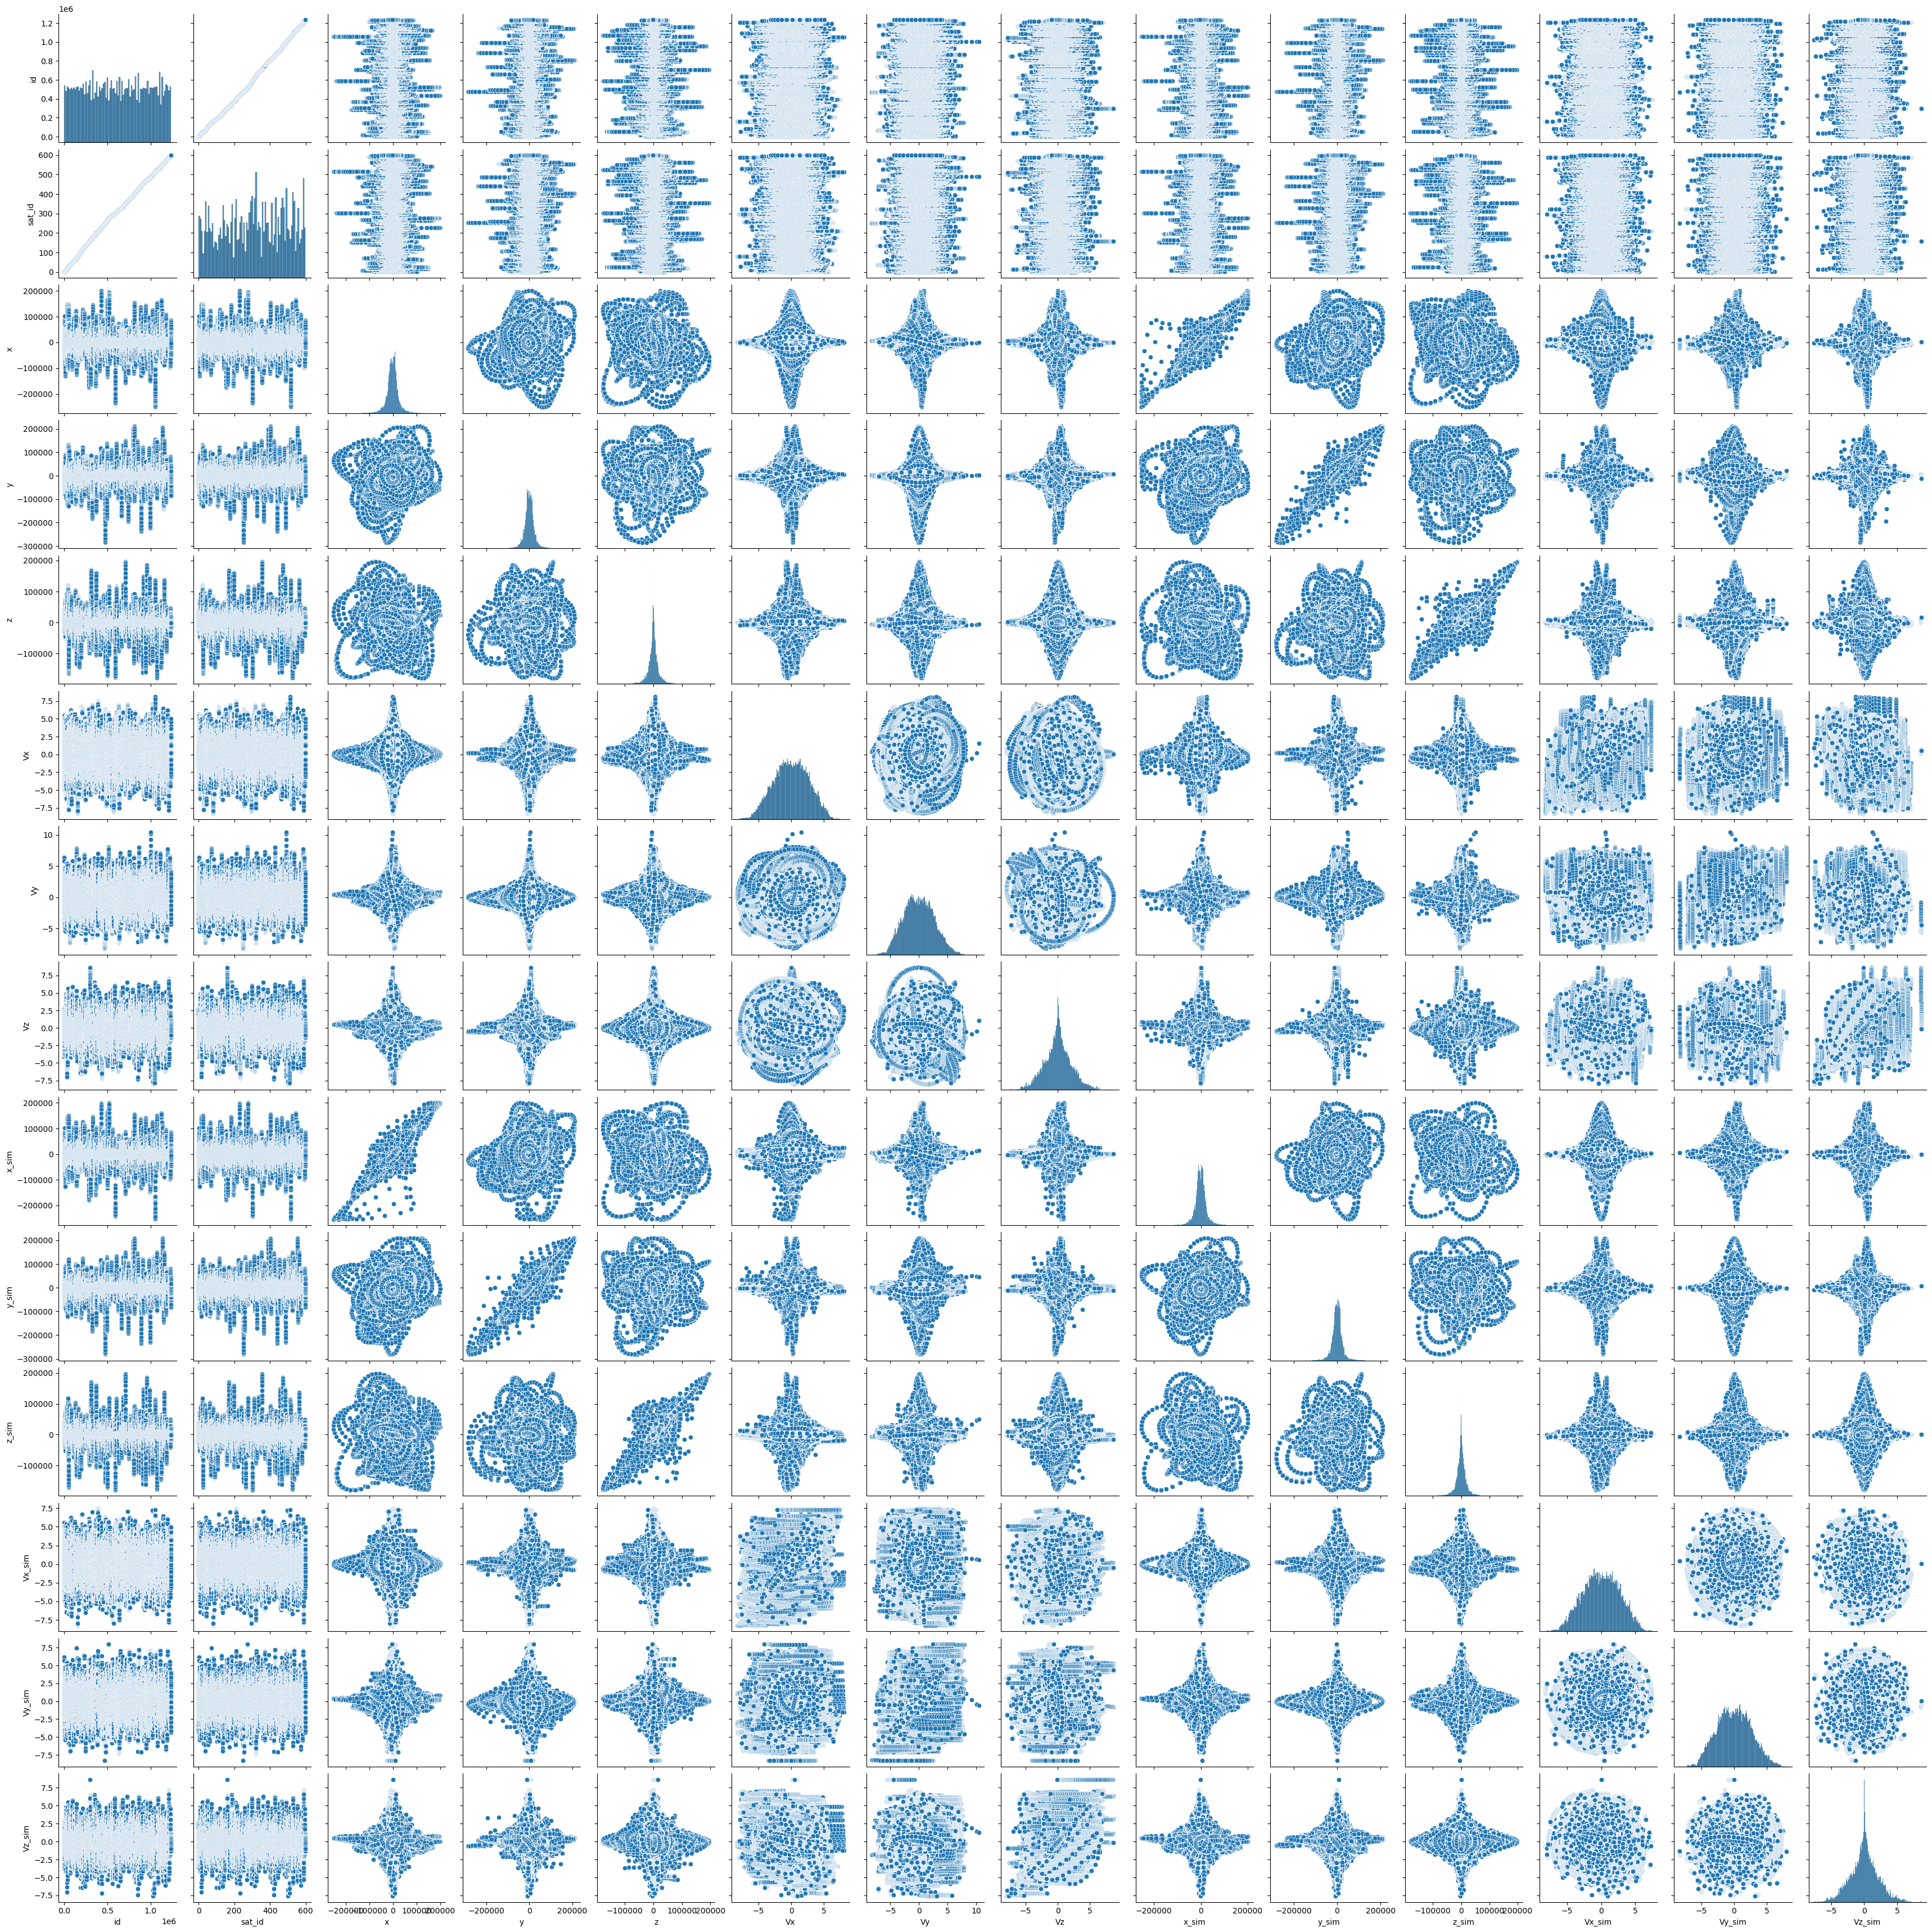

In [5]:
sns.pairplot(train)

In [6]:
train.columns

Index(['id', 'epoch', 'sat_id', 'x', 'y', 'z', 'Vx', 'Vy', 'Vz', 'x_sim',
       'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim'],
      dtype='object')

In [7]:
X=train[['id','sat_id','x_sim','y_sim','z_sim','Vx_sim','Vy_sim','Vz_sim']].copy()
y=train[['x','y','z','Vx','Vy','Vz']]

In [8]:
X

id  sat_id         x_sim         y_sim         z_sim    Vx_sim  \
0             0       0  -8843.131454  13138.221690 -20741.615306 -0.907527   
1             1       0 -10555.500066   1649.289367 -24473.089556 -0.303704   
2             2       0 -10571.858472 -10145.939908 -24271.169776  0.274880   
3             3       0  -9149.620794 -20618.200201 -20765.019094  0.712437   
4             4       0  -6729.358857 -28902.271436 -14992.399986  0.989382   
...         ...     ...           ...           ...           ...       ...   
503222  1233684     599 -22847.208402     80.070907   4444.798405  0.870781   
503223  1233685     599 -20717.460440   6016.252299   3592.204365  2.003622   
503224  1233686     599 -16847.612994  11429.130312   2439.160526  3.186335   
503225  1233687     599 -11273.779239  15659.892239   1041.308701  4.253614   
503226  1233688     599  -4352.858942  17980.888207   -478.128914  4.945428   

          Vy_sim    Vz_sim  
0      -3.804930 -2.024133  
1      -4.269816 -0.616468  
2      -4.046788  0.718768  
3      -3.375202  1.718306  
4      -2.522618  2.342237  
...          ...       ...  
503222  4.035965 -0.467196  
503223  3.872352 -0.675867  
503224  3.315717 -0.865266  
503225  2.276720 -0.996589  
503226  0.770715 -1.020298  

[503227 rows x 8 columns]

In [9]:
min_max_scaler = preprocessing.MinMaxScaler()
X_scale = min_max_scaler.fit_transform(X)

In [10]:
X_scale

0    1         2         3         4         5         6  \
0       0.000000e+00  0.0  0.540117  0.601030  0.421117  0.467983  0.277270   
1       8.105777e-07  0.0  0.536360  0.577700  0.411265  0.506504  0.248783   
2       1.621155e-06  0.0  0.536325  0.553749  0.411798  0.543415  0.262449   
3       2.431733e-06  0.0  0.539445  0.532485  0.421055  0.571329  0.303603   
4       3.242311e-06  0.0  0.544754  0.515663  0.436295  0.588997  0.355847   
...              ...  ...       ...       ...       ...       ...       ...   
503222  9.999968e-01  1.0  0.509394  0.574514  0.487611  0.581431  0.757744   
503223  9.999976e-01  1.0  0.514066  0.586568  0.485360  0.653702  0.747718   
503224  9.999984e-01  1.0  0.522556  0.597559  0.482316  0.729154  0.713608   
503225  9.999992e-01  1.0  0.534785  0.606150  0.478625  0.797242  0.649941   
503226  1.000000e+00  1.0  0.549968  0.610863  0.474614  0.841377  0.557656   

               7  
0       0.343605  
1       0.430215  
2       0.512369  
3       0.573868  
4       0.612257  
...          ...  
503222  0.439400  
503223  0.426561  
503224  0.414907  
503225  0.406827  
503226  0.405369  

[503227 rows x 8 columns]

In [11]:
X_train,Y_train=X_scale, y
print(X_train.shape,Y_train.shape)

(503227, 8) (503227, 6)


In [12]:
Y_train

x             y             z        Vx        Vy        Vz
0       -8855.823863  13117.780146 -20728.353233 -0.908303 -3.808436 -2.022083
1      -10567.672384   1619.746066 -24451.813271 -0.302590 -4.272617 -0.612796
2      -10578.684043 -10180.467460 -24238.280949  0.277435 -4.047522  0.723155
3       -9148.251857 -20651.437460 -20720.381279  0.715600 -3.373762  1.722115
4       -6719.092336 -28929.061629 -14938.907967  0.992507 -2.519732  2.344703
...              ...           ...           ...       ...       ...       ...
503222 -22282.245721   2176.275085   4184.918699  1.255727  4.018148 -0.540243
503223 -19551.683596   7997.489974   3224.501905  2.419800  3.729286 -0.746051
503224 -15064.616469  13079.761912   1975.820551  3.587560  3.009816 -0.920914
503225  -8953.211355  16721.787269    516.231786  4.556922  1.794477 -1.020603
503226  -1717.129724  18218.471698  -1004.927645  5.049138  0.162277 -0.996545

[503227 rows x 6 columns]

In [13]:
Y_train_1 = Y_train.iloc[:, 0]
Y_train_2 = Y_train.iloc[:, 1]
Y_train_3 = Y_train.iloc[:, 2]
Y_train_4 = Y_train.iloc[:, 3]
Y_train_5 = Y_train.iloc[:, 4]
Y_train_6 = Y_train.iloc[:, 5]

In [14]:
Y_train_1

0         -8855.823863
1        -10567.672384
2        -10578.684043
3         -9148.251857
4         -6719.092336
              ...     
503222   -22282.245721
503223   -19551.683596
503224   -15064.616469
503225    -8953.211355
503226    -1717.129724
Name: x, Length: 503227, dtype: float64

In [15]:
nstreams=8
maxfeatures="sqrt"
regressor_1 = RandomForestRegressor(n_estimators=100,n_streams=nstreams)
regressor_1.fit(X_train, Y_train_1)

regressor_2 = RandomForestRegressor(n_estimators=100,n_streams=nstreams)
regressor_2.fit(X_train, Y_train_2)

regressor_3 = RandomForestRegressor(n_estimators=100,n_streams=nstreams)
regressor_3.fit(X_train, Y_train_3)

/home/utkarsh/miniconda3/envs/rapids/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


RandomForestRegressor()

In [16]:
regressor_4 = RandomForestRegressor(n_estimators=200,max_features=maxfeatures,n_streams=nstreams)
regressor_4.fit(X_train, Y_train_4)

RandomForestRegressor()

In [17]:
regressor_5 = RandomForestRegressor(n_estimators=200,max_features=maxfeatures,n_streams=nstreams)
regressor_5.fit(X_train, Y_train_5)

RandomForestRegressor()

In [18]:
regressor_6 = RandomForestRegressor(n_estimators=200,max_features=maxfeatures,n_streams=nstreams)
regressor_6.fit(X_train, Y_train_6)

RandomForestRegressor()

In [19]:
test

id                    epoch  sat_id         x_sim         y_sim  \
0           741  2014-01-25 00:10:20.368       0   3055.948713  29823.972025   
1           742  2014-01-25 00:57:03.369       0  -1337.714907  27971.442402   
2           743  2014-01-25 01:43:46.369       0  -5527.554990  22314.456814   
3           744  2014-01-25 02:30:29.370       0  -8809.978734  13072.425457   
4           745  2014-01-25 03:17:12.370       0 -10576.656721   1580.095041   
...         ...                      ...     ...           ...           ...   
146680  1234089  2014-01-31 22:00:22.602     599 -20717.958996 -16245.240500   
146681  1234090  2014-01-31 22:25:13.240     599 -22673.444496 -11192.339393   
146682  1234091  2014-01-31 22:50:03.878     599 -23461.830699  -5570.167175   
146683  1234092  2014-01-31 23:14:54.515     599 -22858.679929    373.249102   
146684  1234093  2014-01-31 23:39:45.153     599 -20656.328603   6277.934683   

               z_sim    Vx_sim    Vy_sim    Vz_sim  
0        6085.227438 -1.534768 -0.036194 -3.543123  
1       -4000.795465 -1.569222 -1.322302 -3.580785  
2      -13492.029333 -1.376563 -2.703735 -3.090802  
3      -20770.687399 -0.926840 -3.807767 -2.016147  
4      -24475.388535 -0.322902 -4.269041 -0.606292  
...              ...       ...       ...       ...  
146680   5250.939232 -1.653931  3.157321  0.079069  
146681   5243.608790 -0.945328  3.603371 -0.092202  
146682   4966.813869 -0.087089  3.912550 -0.281989  
146683   4396.055679  0.920162  4.021955 -0.485364  
146684   3518.642806  2.050990  3.844021 -0.690707  

[146685 rows x 9 columns]

In [20]:
# Preprocess test data
min_max_scaler = preprocessing.MinMaxScaler()
test=test[['id','sat_id','x_sim','y_sim','z_sim','Vx_sim','Vy_sim','Vz_sim']].copy()
X_test = min_max_scaler.fit_transform(test)


# Make predictions
y_pred_1 = regressor_1.predict(X_test)
y_pred_2 = regressor_2.predict(X_test)
y_pred_3 = regressor_3.predict(X_test)
y_pred_4 = regressor_4.predict(X_test)
y_pred_5 = regressor_5.predict(X_test)
y_pred_6 = regressor_6.predict(X_test)

# Calculate R-squared values
r2_1 = r2_score(key.iloc[:, 0], y_pred_1)
r2_2 = r2_score(key.iloc[:, 1], y_pred_2)
r2_3 = r2_score(key.iloc[:, 2], y_pred_3)
r2_4 = r2_score(key.iloc[:, 3], y_pred_4)
r2_5 = r2_score(key.iloc[:, 4], y_pred_5)
r2_6 = r2_score(key.iloc[:, 5], y_pred_6)

# Calculate overall R-squared value
overall_r2 = (r2_1 + r2_2 + r2_3 + r2_4 + r2_5 + r2_6) / 6
overall_r2

0.8058233493100952

In [21]:
print(r2_1,r2_2,r2_3,r2_4,r2_5,r2_6)

0.8826156919456841 0.878959674879684 0.8976227531026469 0.733773735565256 0.7201986894265483 0.721769550940752
